In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest

In [95]:
# データセットの読み込み
train_data = pd.read_csv('./titanic/train.csv')
test_data = pd.read_csv('./titanic/test.csv')

# train_dataとtest_dataの連結
test_data['Survived'] = np.nan
df = pd.concat([train_data, test_data], ignore_index=True, sort=False)

# dfの情報
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [96]:
# ------------ Age ------------
# Age を Pclass, Sex, Parch, SibSp からランダムフォレストで推定
from sklearn.ensemble import RandomForestRegressor

# 推定に使用する項目を指定
age_df = df[['Age', 'Pclass','Sex','Parch','SibSp']]

# ラベル特徴量をワンホットエンコーディング
age_df=pd.get_dummies(age_df)

# 学習データとテストデータに分離し、numpyに変換
known_age = age_df[age_df.Age.notnull()].values  
unknown_age = age_df[age_df.Age.isnull()].values

# 学習データをX, yに分離
X = known_age[:, 1:]  
y = known_age[:, 0]

# ランダムフォレストで推定モデルを構築
rfr = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rfr.fit(X, y)

# 推定モデルを使って、テストデータのAgeを予測し、補完
predictedAges = rfr.predict(unknown_age[:, 1:])
df.loc[(df.Age.isnull()), 'Age'] = predictedAges

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


C:\Users\Owner\AppData\Local\Temp\ipykernel_17900\542509138.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sex', y='Survived', data=df, palette='Set3')


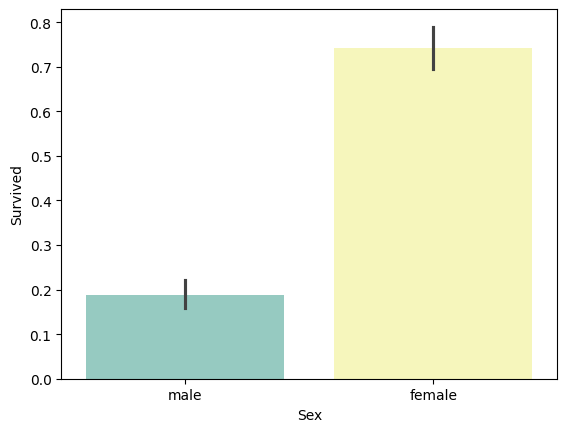

In [97]:
# Sexと生存率の関係 
sns.barplot(x='Sex', y='Survived', data=df, palette='Set3')
plt.show()

c:\Users\Owner\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
c:\Users\Owner\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)


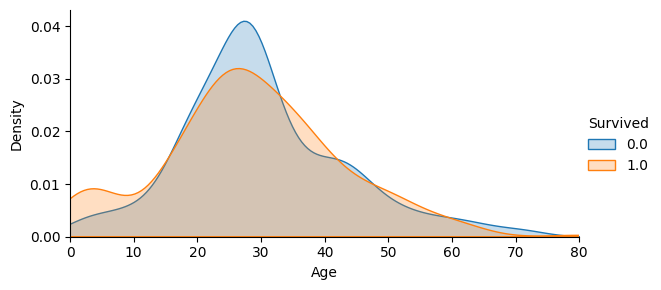

In [98]:
# 年齢別生存曲線と死亡曲線
facet = sns.FacetGrid(df[0:890], hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df.loc[0:890,'Age'].max()))
facet.add_legend()
plt.show()


C:\Users\Owner\AppData\Local\Temp\ipykernel_17900\374236940.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
C:\Users\Owner\AppData\Local\Temp\ipykernel_17900\374236940.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Title', y='Survived', data=df, palette='Set3')


<Axes: xlabel='Title', ylabel='Survived'>

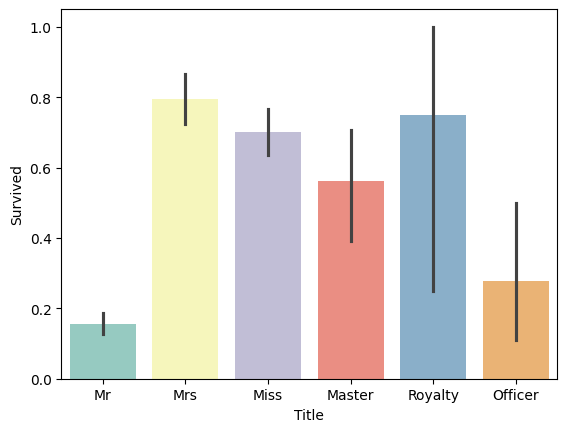

In [99]:
# ------------ Name --------------
# Nameから敬称(Title)を抽出し、グルーピング
df['Title'] = df['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
df['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
df['Title'].replace(['Don', 'Sir',  'the Countess', 'Lady', 'Dona'], 'Royalty', inplace=True)
df['Title'].replace(['Mme', 'Ms'], 'Mrs', inplace=True)
df['Title'].replace(['Mlle'], 'Miss', inplace=True)
df['Title'].replace(['Jonkheer'], 'Master', inplace=True)
sns.barplot(x='Title', y='Survived', data=df, palette='Set3')


In [100]:
# ------------ Surname ------------
# NameからSurname(苗字)を抽出
df['Surname'] = df['Name'].map(lambda name:name.split(',')[0].strip())

# 同じSurname(苗字)の出現頻度をカウント(出現回数が2以上なら家族)
df['FamilyGroup'] = df['Surname'].map(df['Surname'].value_counts()) 


In [101]:
# 家族で16才以下または女性の生存率
Female_Child_Group=df.loc[(df['FamilyGroup']>=2) & ((df['Age']<=16) | (df['Sex']=='female'))]
Female_Child_Group=Female_Child_Group.groupby('Surname')['Survived'].mean()
print(Female_Child_Group.value_counts())

Survived
1.000000    113
0.000000     32
0.750000      2
0.500000      1
0.333333      1
0.142857      1
Name: count, dtype: int64


In [102]:
# 家族で16才超えかつ男性の生存率
Male_Adult_Group=df.loc[(df['FamilyGroup']>=2) & (df['Age']>16) & (df['Sex']=='male')]
Male_Adult_List=Male_Adult_Group.groupby('Surname')['Survived'].mean()
print(Male_Adult_List.value_counts())

Survived
0.000000    115
1.000000     21
0.500000      6
0.333333      2
0.250000      1
Name: count, dtype: int64


In [103]:
# デッドリストとサバイブリストの作成
Dead_list=set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)
Survived_list=set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==1)].index)

# デッドリストとサバイブリストの表示
print('Dead_list = ', Dead_list)
print('Survived_list = ', Survived_list)

# デッドリストとサバイブリストをSex, Age, Title に反映させる
df.loc[(df['Survived'].isnull()) & (df['Surname'].apply(lambda x:x in Dead_list)),\
             ['Sex','Age','Title']] = ['male',28.0,'Mr']
df.loc[(df['Survived'].isnull()) & (df['Surname'].apply(lambda x:x in Survived_list)),\
             ['Sex','Age','Title']] = ['female',5.0,'Mrs']


Dead_list =  {'Oreskovic', 'Lahtinen', 'Lefebre', 'Skoog', 'Turpin', 'Barbara', 'Van Impe', 'Ilmakangas', 'Rice', 'Elias', 'Arnold-Franchi', 'Caram', 'Zabour', 'Canavan', 'Sage', 'Vander Planke', 'Robins', 'Bourke', 'Goodwin', 'Johnston', 'Lobb', 'Jussila', 'Palsson', 'Boulos', 'Rosblom', 'Ford', 'Danbom', 'Attalah', 'Strom', 'Olsson', 'Cacic', 'Panula'}
Survived_list =  {'Beckwith', 'Cardeza', 'Nakid', 'Taylor', 'Jonsson', 'Duff Gordon', 'Dick', 'Goldenberg', 'Frolicher-Stehli', 'Harder', 'Chambers', 'Greenfield', 'Frauenthal', 'Jussila', 'Bishop', 'Beane', 'Kimball', 'McCoy', 'Moubarek', 'Bradley', 'Daly'}


In [104]:
# ----------- Fare -------------
# 欠損値を Embarked='S', Pclass=3 の平均値で補完
fare=df.loc[(df['Embarked'] == 'S') & (df['Pclass'] == 3), 'Fare'].median()
df['Fare']=df['Fare'].fillna(fare)


In [105]:
# ----------- Family -------------
# Family = SibSp + Parch + 1 を特徴量とし、グルーピング
df['Family']=df['SibSp']+df['Parch']+1
df.loc[(df['Family']>=2) & (df['Family']<=4), 'Family_label'] = 2
df.loc[(df['Family']>=5) & (df['Family']<=7) | (df['Family']==1), 'Family_label'] = 1  # == に注意
df.loc[(df['Family']>=8), 'Family_label'] = 0


C:\Users\Owner\AppData\Local\Temp\ipykernel_17900\3130724292.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TicketGroup', y='Survived', data=df, palette='Set3')


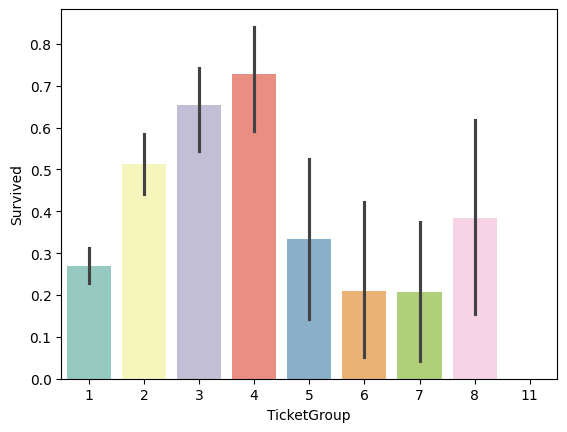

In [106]:
# ----------- Ticket ----------------
# 同一Ticketナンバーの人が何人いるかを特徴量として抽出
Ticket_Count = dict(df['Ticket'].value_counts())
df['TicketGroup'] = df['Ticket'].map(Ticket_Count)
sns.barplot(x='TicketGroup', y='Survived', data=df, palette='Set3')
plt.show()


C:\Users\Owner\AppData\Local\Temp\ipykernel_17900\3694857350.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Ticket_label', y='Survived', data=df, palette='Set3')


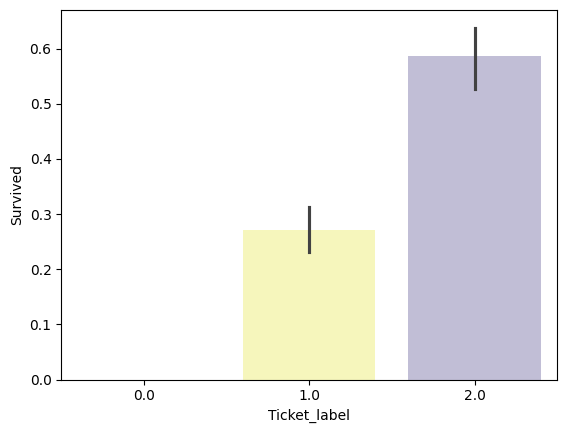

In [107]:
# 生存率で3つにグルーピング
df.loc[(df['TicketGroup']>=2) & (df['TicketGroup']<=4), 'Ticket_label'] = 2
df.loc[(df['TicketGroup']>=5) & (df['TicketGroup']<=8) | (df['TicketGroup']==1), 'Ticket_label'] = 1  
df.loc[(df['TicketGroup']>=11), 'Ticket_label'] = 0
sns.barplot(x='Ticket_label', y='Survived', data=df, palette='Set3')
plt.show()


C:\Users\Owner\AppData\Local\Temp\ipykernel_17900\3627864716.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cabin_label', y='Survived', data=df, palette='Set3')


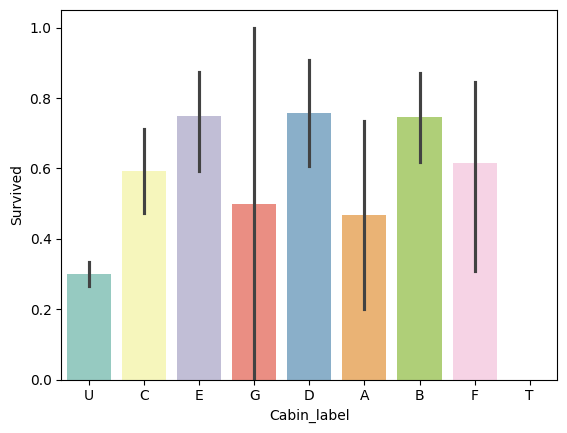

In [108]:
# ------------- Cabin ----------------
# Cabinの先頭文字を特徴量とする(欠損値は U )
df['Cabin'] = df['Cabin'].fillna('Unknown')
df['Cabin_label']=df['Cabin'].str.get(0)
sns.barplot(x='Cabin_label', y='Survived', data=df, palette='Set3')
plt.show()


In [109]:
# ---------- Embarked ---------------
# 欠損値をSで補完
df['Embarked'] = df['Embarked'].fillna('S') 


In [119]:
df.to_csv("./titanic/processed_data.csv", index=False)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Survived       891 non-null    float64
 1   Pclass         1309 non-null   int64  
 2   Age            1309 non-null   float64
 3   Fare           1309 non-null   float64
 4   Family_label   1309 non-null   float64
 5   Ticket_label   1309 non-null   float64
 6   Sex_female     1309 non-null   bool   
 7   Sex_male       1309 non-null   bool   
 8   Embarked_C     1309 non-null   bool   
 9   Embarked_Q     1309 non-null   bool   
 10  Embarked_S     1309 non-null   bool   
 11  Title_Master   1309 non-null   bool   
 12  Title_Miss     1309 non-null   bool   
 13  Title_Mr       1309 non-null   bool   
 14  Title_Mrs      1309 non-null   bool   
 15  Title_Officer  1309 non-null   bool   
 16  Title_Royalty  1309 non-null   bool   
 17  Cabin_label_A  1309 non-null   bool   
 18  Cabin_la

In [111]:
# ------------- 前処理 ---------------
# 推定に使用する項目を指定
df = df[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','Family_label','Cabin_label','Ticket_label']]

# ラベル特徴量をワンホットエンコーディング
df = pd.get_dummies(df)

# データセットを trainとtestに分割
train = df[df['Survived'].notnull()]
test = df[df['Survived'].isnull()].drop('Survived',axis=1)

# データフレームをnumpyに変換
X = train.values[:,1:]  
y = train.values[:,0] 
test_x = test.values


In [112]:
# 特徴量選択のためにSelectKBestを使用
selector = SelectKBest(k=20)
selector.fit(X, y)

# 選択された特徴量を取得
selected_features = selector.get_support(indices=True)
selected_feature_names = df.columns[1:][selected_features]

print("Selected features:", selected_feature_names)

Selected features: Index(['Pclass', 'Age', 'Fare', 'Family_label', 'Ticket_label', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_S', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Royalty', 'Cabin_label_B',
       'Cabin_label_C', 'Cabin_label_D', 'Cabin_label_E', 'Cabin_label_F',
       'Cabin_label_U'],
      dtype='object')


In [113]:
X_selected = selector.transform(X)
y_class = y.astype(int)
test_x_selected = selector.transform(test_x)

In [114]:
from sklearn.ensemble import RandomForestClassifier

# ランダムフォレストモデルのインスタンスを作成
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# モデルを学習
clf.fit(X_selected, y_class)
# モデルの精度を評価
accuracy = clf.score(X_selected, y_class)
print(f"Accuracy: {accuracy}")

# テストデータに対して予測
predictions = clf.predict(test_x_selected)

Accuracy: 0.9876543209876543


In [115]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# データ型の変換
X_selected = np.array(X_selected, dtype=np.float32)
y_class = np.array(y_class, dtype=np.float32)
test_x_selected = np.array(test_x_selected, dtype=np.float32)
# モデルの構築
model = Sequential()
model.add(Dense(64, input_dim=X_selected.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# モデルのコンパイル
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# モデルの学習
model.fit(X_selected, y_class, epochs=500, batch_size=32, validation_split=0.2)

# テストデータに対して予測
nn_predictions = model.predict(test_x_selected)
nn_predictions = (nn_predictions > 0.5).astype(int).flatten()

# モデルの精度を評価
loss, accuracy = model.evaluate(X_selected, y_class)
print(f"Neural Network Accuracy: {accuracy}")

Epoch 1/500
23/23 [==============================] - 1s 11ms/step - loss: 3.8216 - accuracy: 0.5225 - val_loss: 0.7275 - val_accuracy: 0.7039
Epoch 2/500
23/23 [==============================] - 0s 10ms/step - loss: 2.7486 - accuracy: 0.5478 - val_loss: 0.6912 - val_accuracy: 0.7095
Epoch 3/500
23/23 [==============================] - 0s 5ms/step - loss: 2.3115 - accuracy: 0.5674 - val_loss: 0.6024 - val_accuracy: 0.7263
Epoch 4/500
23/23 [==============================] - 0s 4ms/step - loss: 1.6162 - accuracy: 0.6250 - val_loss: 0.5553 - val_accuracy: 0.7318
Epoch 5/500
23/23 [==============================] - 0s 4ms/step - loss: 1.4641 - accuracy: 0.5772 - val_loss: 0.5925 - val_accuracy: 0.6816
Epoch 6/500
23/23 [==============================] - 0s 4ms/step - loss: 1.1988 - accuracy: 0.5716 - val_loss: 0.6381 - val_accuracy: 0.6704
Epoch 7/500
23/23 [==============================] - 0s 5ms/step - loss: 1.2445 - accuracy: 0.6067 - val_loss: 0.6277 - val_accuracy: 0.6872
Epoch 8/500

In [118]:
# 予測結果をデータフレームに変換
submission = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],
    "Survived": predictions
})

# CSVファイルとして保存
submission.to_csv("./titanic/submission.csv", index=False)